<a href="https://colab.research.google.com/github/NicKomarov/comp_lingv_laba2/blob/main/comp_lingv_laba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

import tensorflow as tf
import transformers #huggingface transformers library
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
from collections import Counter

In [2]:
path = kagglehub.dataset_download("rmisra/news-category-dataset")

files = os.listdir(path)
for file in files:
    print(file)

100%|██████████| 26.5M/26.5M [00:00<00:00, 137MB/s] 

Extracting files...


News_Category_Dataset_v3.json


In [3]:
df = pd.read_json(os.path.join(path, "News_Category_Dataset_v3.json"), lines = True)
print(df)

                                                     link  \
0       https://www.huffpost.com/entry/covid-boosters-...   
1       https://www.huffpost.com/entry/american-airlin...   
2       https://www.huffpost.com/entry/funniest-tweets...   
3       https://www.huffpost.com/entry/funniest-parent...   
4       https://www.huffpost.com/entry/amy-cooper-lose...   
...                                                   ...   
209522  https://www.huffingtonpost.com/entry/rim-ceo-t...   
209523  https://www.huffingtonpost.com/entry/maria-sha...   
209524  https://www.huffingtonpost.com/entry/super-bow...   
209525  https://www.huffingtonpost.com/entry/aldon-smi...   
209526  https://www.huffingtonpost.com/entry/dwight-ho...   

                                                 headline   category  \
0       Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1       American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2       23 Of The Funniest Tweets About Cats And Do

In [4]:
df['category'].value_counts()

,count
category,
POLITICS,35602
WELLNESS,17945
ENTERTAINMENT,17362
TRAVEL,9900
STYLE & BEAUTY,9814
PARENTING,8791
HEALTHY LIVING,6694
QUEER VOICES,6347
FOOD & DRINK,6340


In [5]:
df.category = df.category.map(lambda x: "PARENTS" if x == "PARENTING" else x)

# top 5 largest categories
top_categories = df['category'].value_counts().nlargest(5).index

# filter dataset to only top 5 categories
df = df[df['category'].isin(top_categories)]
df['category'].value_counts()

,count
category,
POLITICS,35602
WELLNESS,17945
ENTERTAINMENT,17362
PARENTS,12746
TRAVEL,9900


In [6]:
def count_words(text):
    return len(text.split())


# since I am using BERT as the model, I am converting headlines and descriptions into lower case
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['short_description'] = df['short_description'].apply(lambda descr: str(descr).lower())


# create 'full_descr' column by combining 'headline' and 'short_description'
df['full_descr'] = df['headline'].str.strip() + ' ' + df['short_description'].str.strip()
# apply the count_words function to the 'full_descr' column and create a new 'full_descr_len' column
df['full_descr_len'] = df['full_descr'].apply(count_words)
df.head()


# filter the DataFrame to remove rows where "full_descr_len" is zero
df = df[df['full_descr_len'] != 0]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93554 entries, 3 to 209513
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   link               93554 non-null  object        
 1   headline           93554 non-null  object        
 2   category           93554 non-null  object        
 3   short_description  93554 non-null  object        
 4   authors            93554 non-null  object        
 5   date               93554 non-null  datetime64[ns]
 6   full_descr         93554 non-null  object        
 7   full_descr_len     93554 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 6.4+ MB


In [9]:
# drop every column except "categories" and "full_descr_len"
df = df.drop(["link", "headline", "short_description","full_descr_len","date","authors"], axis=1)
df.head()

,category,full_descr
3,PARENTS,the funniest tweets from parents this week (se...
20,ENTERTAINMENT,golden globes returning to nbc in january afte...
21,POLITICS,biden says u.s. forces would defend taiwan if ...
24,POLITICS,‘beautiful and sad at the same time’: ukrainia...
28,ENTERTAINMENT,james cameron says he 'clashed' with studio be...


In [10]:
# download the stopwords dataset
nltk.download('stopwords')

# define a function to remove stopwords from text
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# apply stopwords removal to your DataFrame
df['full_descr'] = df['full_descr'].apply(remove_stopwords)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,category,full_descr
3,PARENTS,"funniest tweets parents week (sept. 17-23) ""ac..."
20,ENTERTAINMENT,golden globes returning nbc january year off-a...
21,POLITICS,biden says u.s. forces would defend taiwan chi...
24,POLITICS,‘beautiful sad time’: ukrainian cultural festi...
28,ENTERTAINMENT,james cameron says 'clashed' studio 'avatar' r...
...,...,...
209478,TRAVEL,tea time beneath western ghats (photos) steppe...
209479,WELLNESS,beginning: surprising advice centenarian great...
209481,PARENTS,teen responsibility happen -- nurtured feel ki...
209512,ENTERTAINMENT,"sundance, ice-t, shades american race cinema r..."


In [13]:
X = df['full_descr']
y = df['category']


n_splits = 1
stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=42)


for train_index, test_index in stratified_split.split(X, y):
    # split the data into train and test
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

In [14]:
# define the DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=5)

# tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True, max_length=90)
    return tokens


train_df['TokenizedText'] = train_df['full_descr'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['full_descr'].apply(tokenize_text)


# initialize the LabelEncoder
label_encoder = LabelEncoder()

# encode the 'category' column to numerical labels
train_df['category'] = label_encoder.fit_transform(train_df['category'])
test_df['category'] = label_encoder.transform(test_df['category'])


# convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['category'].tolist())

X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['category'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-14-e09ebe023443>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TokenizedText'] = train_df['full_descr'].apply(tokenize_text)
<ipython-input-14-e09ebe023443>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [15]:
# define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# use gpus
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# using AdamW optimization
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [16]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for batch in tqdm(dataloader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


# training loop
for epoch in range(2):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}")

Training: 100%|██████████| 4386/4386 [09:58<00:00,  7.33it/s]


Epoch 1/2, Train Loss: 0.3217


Training: 100%|██████████| 4386/4386 [10:02<00:00,  7.28it/s]

Epoch 2/2, Train Loss: 0.1807


Evaluating: 100%|██████████| 1462/1462 [01:03<00:00, 23.05it/s]


Confusion Matrix:
[[4070  104  101   30   36]
 [  82 2834   52   43  176]
 [ 258   81 8426   79   56]
 [  64   29   27 2319   36]
 [  58  200   54  123 4051]]
Classification Report:
               precision    recall  f1-score   support

ENTERTAINMENT       0.90      0.94      0.92      4341
      PARENTS       0.87      0.89      0.88      3187
     POLITICS       0.97      0.95      0.96      8900
       TRAVEL       0.89      0.94      0.91      2475
     WELLNESS       0.93      0.90      0.92      4486

     accuracy                           0.93     23389
    macro avg       0.91      0.92      0.92     23389
 weighted avg       0.93      0.93      0.93     23389



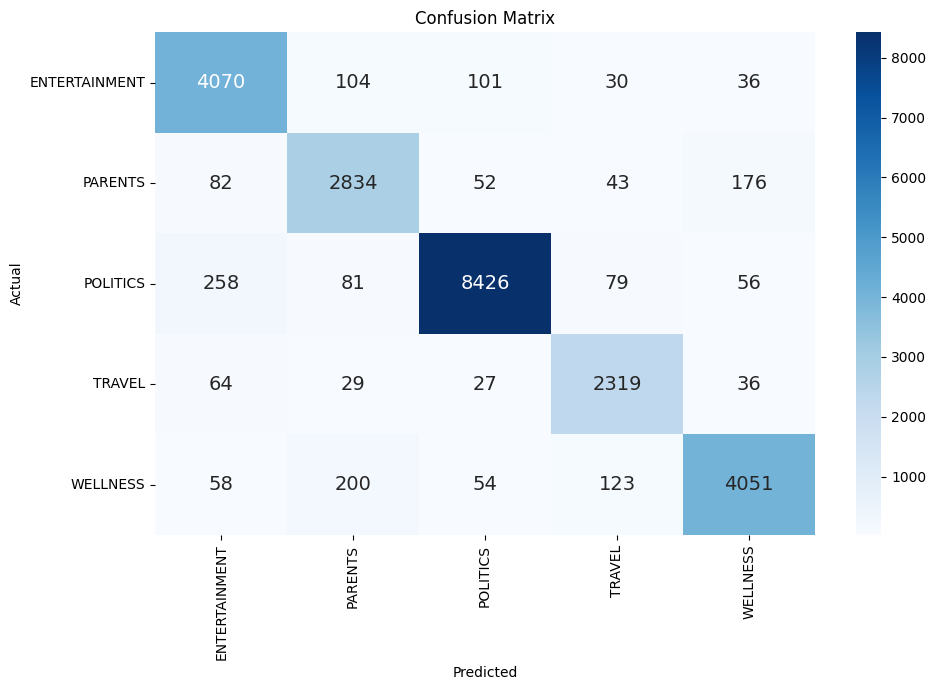

In [18]:
# evaluate the model on the test dataset
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



# inverse transform the numerical labels back to original labels
y_true_orig_labels = label_encoder.inverse_transform(y_true)
y_pred_orig_labels = label_encoder.inverse_transform(y_pred)


# calculate confusion matrix and classification report
cm = confusion_matrix(y_true_orig_labels, y_pred_orig_labels)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_true_orig_labels, y_pred_orig_labels)
print("Classification Report:")
print(report)


# create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()